# Primordial Earth (HERMES tutorial)
There are a wide variety of problems in solar system astronomy requiring accurate integration of N-bodies undergoing close encounters and/or collisions. Standard choices such as the Wisdom-Holman integrator are insufficient for these types of problems, and one must instead turn to more exotic algorithms. 

In this example we investigate the primordial Earth embedded in a disk of planetesimals, integrating it for a short period of time using the HERMES integrator. HERMES is a hybrid integration scheme which combines the WHFAST and IAS15 algorithms for the optimal balance between speed and accuracy. 

In [1]:
import rebound
import numpy as np

First let's choose the basic properties required for the HERMES integrator. In particular, we are:  
* Setting planetesimals to *semi-active* mode, which means they can influence active bodies but not other semi-active ones.
* Merging collisions according to conservation of momentum
* Removing particles that leave our pre-defined box.
* Tracking the energy lost due to ejections or collisions.  

Other choices are certainly possible.

In [2]:
sim = rebound.Simulation()

#integrator options
sim.integrator = "hermes"
sim.ri_hermes.hill_switch_factor = 3.
sim.ri_hermes.radius_switch_factor = 20.
sim.dt = 0.005
sim.testparticle_type = 1

#collision and boundary options
sim.collision = "direct"
sim.collision_resolve = "merge"
sim.collision_resolve_keep_sorted = 1
sim.boundary = "open"
boxsize = 3.
sim.configure_box(boxsize)
sim.track_energy_offset = 1

Now that the setup is complete, it's time to add some bodies! When using the HERMES integrator it's always important to add active bodies first and semi-active bodies later. The "sim.N_active" variable separates massive bodies from semi-active/test bodies.

In [3]:
sim.add(m=1.)
sim.add(m=3e-6,r=5e-5,a=1,e=0.05,f=np.pi)
sim.N_active = sim.N

Now, let's create our planetesimal disk. First we need to make use of three different distribution functions - powerlaw, uniform and rayleigh.

In [4]:
def rand_powerlaw(slope, min_v, max_v):
    y = np.random.uniform()
    pow_max = pow(max_v, slope+1.)
    pow_min = pow(min_v, slope+1.)
    return pow((pow_max-pow_min)*y + pow_min, 1./(slope+1.))

def rand_uniform(minimum, maximum):
    return np.random.uniform()*(maximum-minimum)+minimum

def rand_rayleigh(sigma):
    return sigma*np.sqrt(-2*np.log(np.random.uniform()))

Next, let's set up the basic properties of our planetesimal disk. For this simple example we are assuming that all planetesimals have the same mass and radius. Other, more complicated choices are certainly possible.

In [5]:
N_pl = 100
Mtot_disk = 10*sim.particles[1].m
m_pl = Mtot_disk / float(N_pl)
r_pl = 2e-5
powerlaw = 0
disk_min_a = 0.95
disk_max_a = 1.05
rayleigh_sigma = 0.01

Now let's add our planetesimals to the simulation!

In [6]:
np.random.seed(42)
while sim.N < (N_pl + sim.N_active):
    a = rand_powerlaw(powerlaw, disk_min_a, disk_max_a)
    e = rand_rayleigh(rayleigh_sigma)
    inc = rand_rayleigh(0.5*rayleigh_sigma)
    f = rand_uniform(np.pi-0.1,np.pi+0.1) #initialize planetesimals close to Planet Earth
    sim.add(m=m_pl, r=r_pl, a=a, e=e, inc=inc, Omega=0, omega=0, f=f)

Finally, since the integrator primarily uses the WHFAST algorithm we need to move to the COM frame. In addition, it is always good practice to monitor the change in energy over the course of a simulation, which requires us to calculate it before and after the simulation.

In [7]:
sim.move_to_com()
E0 = sim.calculate_energy()

We can visualize our setup using rebound.OrbitPlot

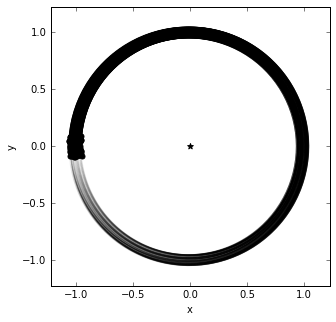

In [8]:
%matplotlib inline
fig = rebound.OrbitPlot(sim, trails=True)

Finally, let's simulate our system for 100 years, and check that our final relative energy error is small. 

In [9]:
sim.integrate(100)
dE = abs((sim.calculate_energy() - E0)/E0)
print dE

2.06133461499e-09
